# Market Regime Classification (XGBoost & LightGBM)

This notebook implements market regime classification using Gradient Boosting models.
**Key Changes**:
1. **Models**: XGBoost and LightGBM instead of Random Forest.
2. **Regularization**: Strict parameters (`max_depth`, `reg_alpha`, `reg_lambda`) to prevent overfitting.
3. **Validation**: `TimeSeriesSplit` to respect temporal order.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Add project root to path
project_root = Path('../../').resolve()
sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Data

In [3]:
# Load merged datasets (Bull/Bear/Side)
# Note: Using a sample file for demonstration if specific regime files aren't generated yet
# In a real scenario, you would load specific regime files or a master dataset
data_path = project_root / 'data' / 'BTCUSDT_2021_2023_1m.csv'
print(f"Loading data from {data_path}...")
df = pd.read_csv(data_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

# Resample to 4H for regime classification (less noise)
df_4h = df.resample('4H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
df_4h = df_4h.dropna()

print(f"Data Shape (4H): {df_4h.shape}")

Loading data from E:\Coding\Crypto_Research\data\BTCUSDT_2021_2023_1m.csv...
Data Shape (4H): (6549, 5)


C:\Users\watte\AppData\Local\Temp\ipykernel_27704\3374104203.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_4h = df.resample('4H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})


## 2. Feature Engineering & Labeling

In [4]:
# Simple Technical Indicators for Features
df_4h['Returns'] = df_4h['Close'].pct_change()
df_4h['SMA_20'] = df_4h['Close'].rolling(window=20).mean()
df_4h['SMA_50'] = df_4h['Close'].rolling(window=50).mean()
df_4h['RSI'] = 100 - (100 / (1 + df_4h['Returns'].rolling(14).apply(lambda x: x[x>0].sum() / abs(x[x<0].sum()) if abs(x[x<0].sum()) > 0 else 1)))
df_4h['Vol_20'] = df_4h['Returns'].rolling(20).std()

# Label: 1 if next 5 periods return > 1%, else 0 (Bullish Regime)
future_returns = df_4h['Close'].shift(-5) / df_4h['Close'] - 1
df_4h['Target'] = (future_returns > 0.01).astype(int)

df_4h = df_4h.dropna()

features = ['Returns', 'SMA_20', 'SMA_50', 'RSI', 'Vol_20']
X = df_4h[features]
y = df_4h['Target']

print(f"Class Balance:\n{y.value_counts(normalize=True)}")

Class Balance:
Target
0    0.696154
1    0.303846
Name: proportion, dtype: float64


## 3. Model Training (Strict Regularization)

In [5]:
# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost with Strict Regularization
model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,            # Shallow trees to prevent overfitting
    learning_rate=0.05,     # Lower learning rate
    subsample=0.8,          # Subsample data
    colsample_bytree=0.8,   # Subsample features
    reg_alpha=0.1,          # L1 Regularization
    reg_lambda=0.1,         # L2 Regularization
    random_state=42,
    n_jobs=-1
)

# LightGBM with Strict Regularization
model_lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Models initialized with strict regularization.")

Models initialized with strict regularization.


## 4. Validation & Evaluation

Running TimeSeries Cross-Validation...
XGBoost CV ROC-AUC: 0.4930 (+/- 0.0271)
LightGBM CV ROC-AUC: 0.4915 (+/- 0.0312)


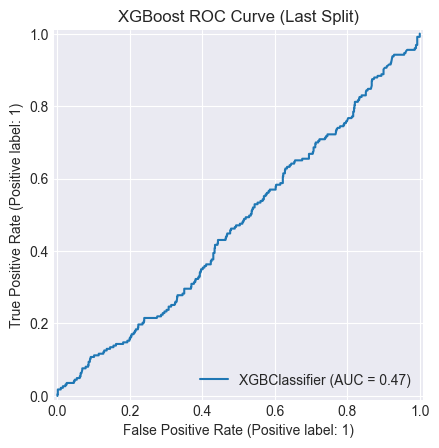

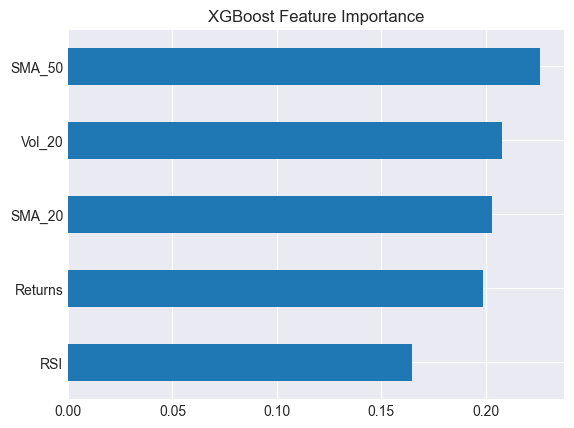

In [6]:
# Cross-Validation Scores (ROC-AUC)
print("Running TimeSeries Cross-Validation...")
scores_xgb = cross_val_score(model_xgb, X, y, cv=tscv, scoring='roc_auc')
scores_lgbm = cross_val_score(model_lgbm, X, y, cv=tscv, scoring='roc_auc')

print(f"XGBoost CV ROC-AUC: {scores_xgb.mean():.4f} (+/- {scores_xgb.std():.4f})")
print(f"LightGBM CV ROC-AUC: {scores_lgbm.mean():.4f} (+/- {scores_lgbm.std():.4f})")

# Train on last split for final visualization
train_index, test_index = list(tscv.split(X))[-1]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

model_xgb.fit(X_train, y_train)

# Plot ROC Curve for XGBoost
RocCurveDisplay.from_estimator(model_xgb, X_test, y_test)
plt.title('XGBoost ROC Curve (Last Split)')
plt.show()

# Feature Importance
importances = pd.Series(model_xgb.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title='XGBoost Feature Importance')
plt.show()